# Определение перспективного тарифа для телеком-компании

Проект направлен на анализ поведения клиентов использующих два различных тарифа (Смарт и Ультра)  

Основной цель проекта- выбрать наиболее перспективный тариф. Определить какой тариф лучше.  

<b>Описание данных:</b>  

<b>Таблица users (информация о пользователях):</b>  
user_id — уникальный идентификатор пользователя  
first_name — имя пользователя  
last_name — фамилия пользователя  
age — возраст пользователя (годы)  
reg_date — дата подключения тарифа (день, месяц, год)  
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
city — город проживания пользователя  
tariff — название тарифного плана  

<b>Таблица calls (информация о звонках):</b>  
id — уникальный номер звонка  
call_date — дата звонка  
duration — длительность звонка в минутах  
user_id — идентификатор пользователя, сделавшего звонок  

<b>Таблица messages (информация о сообщениях):</b>  
id — уникальный номер сообщения  
message_date — дата сообщения  
user_id — идентификатор пользователя, отправившего сообщение  

<b>Таблица internet (информация об интернет-сессиях):</b>  
id — уникальный номер сессии  
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)  
session_date — дата интернет-сессии  
user_id — идентификатор пользователя  

<b>Таблица tariffs (информация о тарифах):</b>  
tariff_name — название тарифа  
rub_monthly_fee — ежемесячная абонентская плата в рублях  
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату  
messages_included — количество сообщений в месяц, включённых в абонентскую плату  
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
rub_per_message — стоимость отправки сообщения сверх тарифного пакета  
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  

<b>План работ:</b>
   - Импортировать данные
   - Проверить каждую таблицу на неверные данные (поиск аномалий и не верных значений) + исправление по возможности
   - Коррекция типов данных
   - Сведение всех таблиц в общий источник данных
   - Оценка ключевых показателей по каждому тарифу
   - Проверка гипотез 
   - Выводы


<b>Импорт библиотек</b>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import math as mt
import numpy as np

<b>Импорт данных</b>

In [2]:
pd.options.display.float_format = '{:.2f}'.format
data_users=pd.read_csv('/datasets/users.csv' )
data_tariffs=pd.read_csv('/datasets/tariffs.csv' )
data_call=pd.read_csv('/datasets/calls.csv' )
data_internet=pd.read_csv('/datasets/internet.csv' )
data_messages=pd.read_csv('/datasets/messages.csv' )

# Первичная обработка таблиц

## Таблица Call
В данной таблице были проведены следующие изменения:  
- Произведено округление звонков вверх до ближайшего целого значения;
- Убраны нулевые по длительности звонки, так как они не поглощают "ресурсы" тарифа;
- Добавлено дополнительное поле МЕСЯЦ для группировки;
- Произведена группировка данных и изменены названия столбцов.  

In [3]:
# обработка таблицы call
data_call['duration']=np.ceil(data_call['duration']) # округление звонков
data_call=data_call.loc[data_call['duration']!=0] # убираем нулевые звонки
data_call['call_date']=pd.to_datetime(data_call['call_date']).dt.to_period('M') # дата для группировки
data_call=data_call.groupby(['user_id','call_date']).agg({'duration':['count','sum']}).reset_index()
data_call.columns = ['user_id','month_user','count_call','sum_call']
display(data_call.head())
data_call.info()

,user_id,month_user,count_call,sum_call
0,1000,2018-05,17,159.00
1,1000,2018-06,28,172.00
2,1000,2018-07,41,340.00
3,1000,2018-08,42,408.00
4,1000,2018-09,46,466.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   user_id     3168 non-null   int64    
 1   month_user  3168 non-null   period[M]
 2   count_call  3168 non-null   int64    
 3   sum_call    3168 non-null   float64  
dtypes: float64(1), int64(2), period[M](1)
memory usage: 99.1 KB


Данные имеют верные типы данных.  
Ниже приведены два графика распределения кол-ва потраченных минут. (визуальная проверка отсутствия выбросов)

Text(0.5, 1.0, 'Распределение пользователей по кол-ву потребленных минут в месяц')

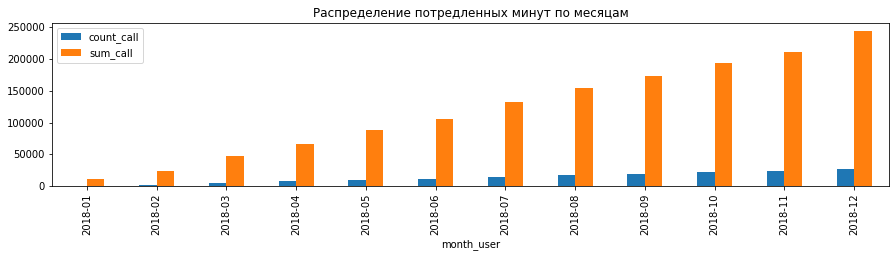

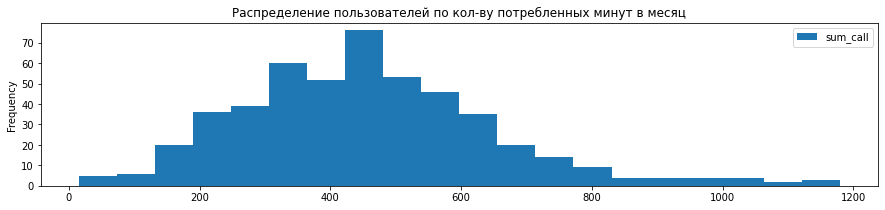

In [4]:
# Проверка
data_call_chek=data_call.pivot_table(index='month_user', values=['count_call','sum_call'] ,aggfunc='sum')
data_call_chek.plot(y=['count_call','sum_call'],kind='bar',figsize=(15,3))
plt.title('Распределение потредленных минут по месяцам')
data_call_chek2=data_call.pivot_table(index='user_id', values='sum_call' ,aggfunc='mean')
data_call_chek2.plot(y='sum_call',kind='hist',bins=20, figsize=(15,3))
plt.title('Распределение пользователей по кол-ву потребленных минут в месяц')


Выводы:  
* На графике по месяцам видно нарастание объема, следовательно, выборка увеличивалась в течение года.  
    Это может негативно отразится на анализе, так как каждый месяцам мы видим разный набор по пользователей.  
* График распределения потребления минут переделал на среднемесячный показатель. Нормальное распределение. Мат. Ожидание в районе 450 минут.


## Таблица internet
В данной таблице были проведены следующие изменения:  
- Произведено округление потребленного интернета вверх до ближайшего целого значения;
- Убраны нулевые по длительности сессии, так как они не поглощают "ресурсы" тарифа;
- Добавлено дополнительное поле МЕСЯЦ для группировки;
- Произведена группировка данных и изменены названия столбцов.

In [5]:
# обработка таблицы internet

data_internet=data_internet.loc[data_internet['mb_used']!=0]# Убираем нулевые сессии
data_internet['session_date']=pd.to_datetime(data_internet['session_date']).dt.to_period('M')# дата группировки
data_internet=data_internet.groupby(['user_id','session_date']).agg({'mb_used':['count','sum']}).reset_index()
data_internet.columns = ['user_id','month_user','count_int','sum_int']
data_internet['sum_int']=np.ceil(data_internet['sum_int']/1024)# округляем потребление трафика и перевел  сразу в гигобайты
display(data_internet.head())
data_internet.info()

,user_id,month_user,count_int,sum_int
0,1000,2018-05,4,3.00
1,1000,2018-06,44,23.00
2,1000,2018-07,28,14.00
3,1000,2018-08,27,14.00
4,1000,2018-09,25,15.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201 entries, 0 to 3200
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   user_id     3201 non-null   int64    
 1   month_user  3201 non-null   period[M]
 2   count_int   3201 non-null   int64    
 3   sum_int     3201 non-null   float64  
dtypes: float64(1), int64(2), period[M](1)
memory usage: 100.2 KB


Данные имеют верные типы данных.  
Ниже приведены два графика распределения кол-ва потраченных минут. (визуальная проверка отсутствия выбросов)

Text(0.5, 1.0, 'Распределение пользователей по кол-ву потребляемого интернета')

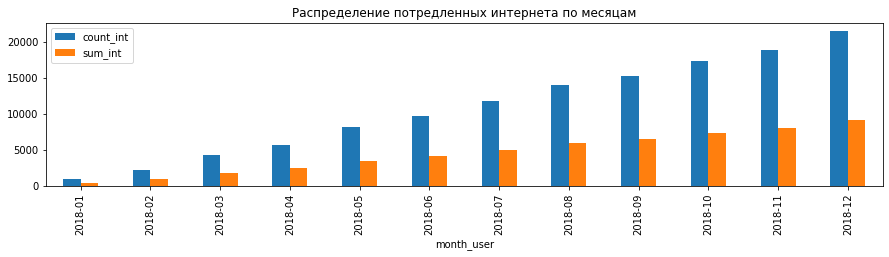

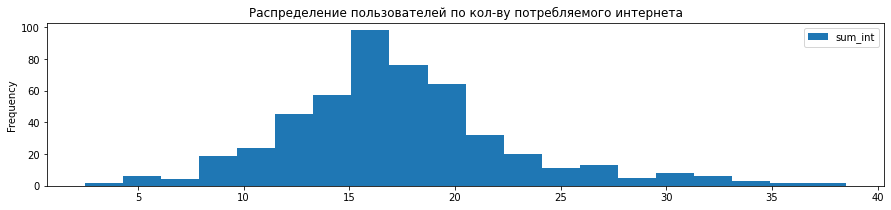

In [6]:
# Проверка
data_internet_chek=data_internet.pivot_table(index='month_user', values=['count_int','sum_int'] ,aggfunc='sum')
data_internet_chek['sum_int']=data_internet_chek['sum_int']
data_internet_chek.plot(y=['count_int','sum_int'],kind='bar',figsize=(15,3))
plt.title('Распределение потредленных интернета по месяцам')
data_internet_chek2=data_internet.pivot_table(index='user_id', values='sum_int' ,aggfunc='mean')
data_internet_chek2.plot(y='sum_int',kind='hist',bins=20, figsize=(15,3))
plt.title('Распределение пользователей по кол-ву потребляемого интернета')

<b>Выводы:</b>  
* Потребление трафика также нарастает к концу периода- выборка постоянно увеличивается
* График распределения имеет форму нормального распределения с центром потребления 15-16 гигабайт.


## Таблица messages
В данной таблице были проведены следующие изменения:  
- Добавлено дополнительное поле МЕСЯЦ для группировки;
- Произведена группировка данных и изменены названия столбцов.

,user_id,month_user,count_mes
0,1000,2018-05,22
1,1000,2018-06,60
2,1000,2018-07,75
3,1000,2018-08,81
4,1000,2018-09,57


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   user_id     2717 non-null   int64    
 1   month_user  2717 non-null   period[M]
 2   count_mes   2717 non-null   int64    
dtypes: int64(2), period[M](1)
memory usage: 63.8 KB


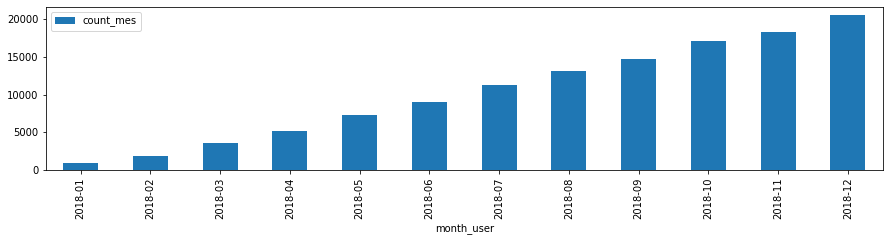

In [7]:
# обработка таблицы message
data_messages.head()
data_messages['message_date']=pd.to_datetime(data_messages['message_date']).dt.to_period('M')
data_messages=data_messages.groupby(['user_id','message_date']).agg({'id':'count'}).reset_index()
data_messages.columns = ['user_id','month_user','count_mes']
data_messages_chek=data_messages.pivot_table(index='month_user', values=['count_mes'] ,aggfunc='sum')
data_messages_chek.plot(y=['count_mes'],kind='bar',figsize=(15,3))
display(data_messages.head())
data_messages.info()

## Таблица User

In [8]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [9]:
# Обработка полей с датой
data_users['churn_date']= pd.to_datetime(data_users['churn_date'])
data_users['reg_date']= pd.to_datetime(data_users['reg_date'])


# Сведение общей таблицы и расчёт доп. показателей

Последовательно объединяем данные из  таблиц потребления (data_call, data_internet, data_messages) с таблицами User и Tariff  тем самым получаем полную картину потребления всех пользователей и знание к какому тарифу они относятся.

In [10]:
# Объединим таблицы  
data_all=data_call.merge(data_internet,on=['user_id','month_user'],how='outer')
data_all=data_all.merge(data_messages,on=['user_id','month_user'],how='outer')
data_all=data_all.merge(data_users, on='user_id',how='left')
data_tariffs=data_tariffs.rename(columns={"tariff_name": "tariff"})
data_all=data_all.merge(data_tariffs, on='tariff',how='left')
data_all.head()

,user_id,month_user,count_call,sum_call,count_int,sum_int,count_mes,age,churn_date,city,...,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,2018-05,17.00,159.00,4.00,3.00,22.00,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,2018-06,28.00,172.00,44.00,23.00,60.00,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,2018-07,41.00,340.00,28.00,14.00,75.00,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,2018-08,42.00,408.00,27.00,14.00,81.00,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,2018-09,46.00,466.00,25.00,15.00,57.00,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [11]:
# Код ревьюера
data_all.isna().sum()

user_id                     0
month_user                  0
count_call                 46
sum_call                   46
count_int                  13
sum_int                    13
count_mes                 497
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [12]:

data_all=data_all.fillna(0) # заменил пропуск
data_all['mb_per_month_included']=data_all['mb_per_month_included']/1024 # преревел значение в гигабайты 


Рассчитываем перерасход потребления для каждого пользователя сверх тарифа 

In [13]:

# Расчёт перерасхода для каждого клиента
data_all['up_sum_call']= np.where(data_all['sum_call']>data_all['minutes_included'],data_all['sum_call']-data_all['minutes_included'],0)   
data_all['up_sum_int']=np.where(data_all['sum_int']>data_all['mb_per_month_included'],data_all['sum_int']-data_all['mb_per_month_included'],0)
data_all['up_count_mes']=np.where(data_all['count_mes']>data_all['messages_included'],data_all['count_mes']-data_all['messages_included'],0)


Рассчитываем общую выручку по каждому пользователю.  
Рассчитываем выручку по каждому пользователю от перерасхода.  
Оцениваем мин/макс показатели.  
График распределения выручки.

Минимальная выручка: 550.0
Максимальная выручка: 6770.0


Text(0.5, 0, 'Выручка')

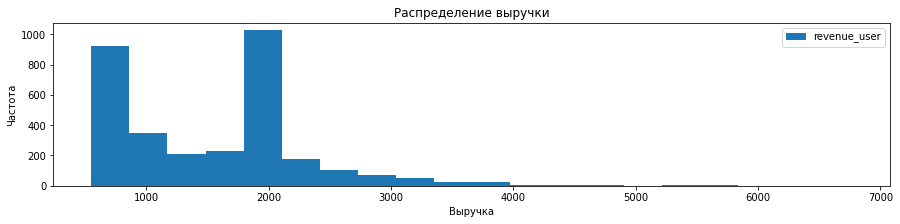

In [14]:
# Расчёт выручки
data_all['revenue_user']=data_all['rub_monthly_fee']+data_all['up_sum_call']*data_all['rub_per_minute']+data_all['up_sum_int']*data_all['rub_per_gb']+data_all['up_count_mes']*data_all['rub_per_message']
# Расчёт выручки от перерасхода
data_all['up_revenue_user']=data_all['up_sum_call']*data_all['rub_per_minute']+data_all['up_sum_int']*data_all['rub_per_gb']+data_all['up_count_mes']*data_all['rub_per_message']

print('Минимальная выручка:',data_all['revenue_user'].min())
print('Максимальная выручка:',data_all['revenue_user'].max())

data_all.plot(y=['revenue_user'],kind='hist',bins=20,figsize=(15,3))
plt.title('Распределение выручки')
plt.ylabel('Частота')
plt.xlabel('Выручка')


**Вывод:** Наличие двух пиков в распределение выручки отражает наличие двух тарифов м концентрацией платежей в районе 550 руб. и 2000 руб.  

#  Оценка тарифов

## Тариф Smart
Выбираем тариф smart и оцениваем сколько средне денег уходит у клиента,  что вызывает наибольшую переплату по тарифу.  

In [15]:
data_all_smart=data_all.loc[data_all['tariff']=='smart'] # выбрали тариф  
data_all_smart.head()

,user_id,month_user,count_call,sum_call,count_int,sum_int,count_mes,age,churn_date,city,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,up_sum_call,up_sum_int,up_count_mes,revenue_user,up_revenue_user
8,1001,2018-11,45.00,430.00,47.00,18.00,0.00,41,0,Москва,...,500,550,200,3,3,0.00,3.00,0.00,1150.00,600.00
9,1001,2018-12,47.00,414.00,35.00,14.00,0.00,41,0,Москва,...,500,550,200,3,3,0.00,0.00,0.00,550.00,0.00
10,1002,2018-06,14.00,117.00,27.00,11.00,4.00,59,0,Стерлитамак,...,500,550,200,3,3,0.00,0.00,0.00,550.00,0.00
11,1002,2018-07,21.00,214.00,44.00,18.00,11.00,59,0,Стерлитамак,...,500,550,200,3,3,0.00,3.00,0.00,1150.00,600.00
12,1002,2018-08,37.00,289.00,50.00,20.00,13.00,59,0,Стерлитамак,...,500,550,200,3,3,0.00,5.00,0.00,1550.00,1000.00


Оценка голоса в тарифе Smart
Среднее кол-во потраченных минут: 419.6348029272315
Макс кол-во потраченных минут: 891.5
Средняя перерасход минут: 45.740558647701505
Средняя переплата по минутам: 137.22167594310451
Средняя доля пользователей тарифа, которые вылетают за лимит по минутам : 0.29397166435427596
Стандартное отклонение по минутам: 190.27103471651876
Дисперсия минут разговора: 36219.31578434428


Text(0.5, 0, 'Кол-во минут')

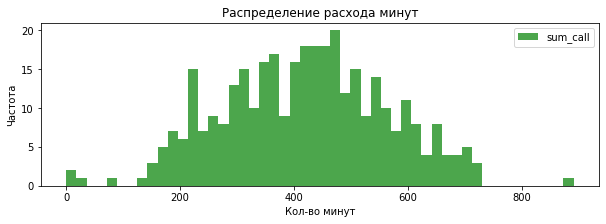

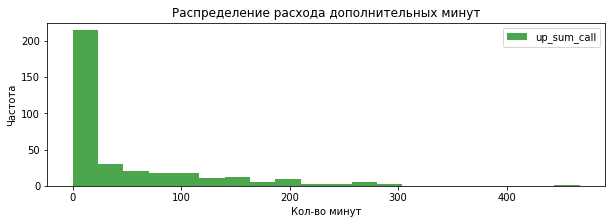

In [16]:
# Расчёт по звонкам для тарифа Smart
# усредняем показатели для каждого пользователя по месяцам:
data_all_smart_p=data_all_smart.pivot_table( index= 'user_id',values=['sum_call','sum_int','count_mes','up_sum_call','up_sum_int','up_count_mes'],aggfunc='mean')

print('Оценка голоса в тарифе Smart')
print('Среднее кол-во потраченных минут:',data_all_smart_p['sum_call'].mean()) 
print('Макс кол-во потраченных минут:',data_all_smart_p['sum_call'].max())
print('Средняя перерасход минут:',data_all_smart_p['up_sum_call'].mean())
print('Средняя переплата по минутам:',data_all_smart_p['up_sum_call'].mean()*3)

# Считаем сколько пользователей имеют перерасход по минутам по месяцам.
data_all_smart_count_hwo_over_call=data_all_smart.query('up_sum_call>0').pivot_table( index= 'month_user',values='up_sum_call',aggfunc='count')
# Считаем сколько пользователей всего в месяце.
data_all_smart_count_hwo_call=data_all_smart.pivot_table( index= 'month_user',values='user_id',aggfunc='count')
# Соединяем два предыдущих шага.
data_all_smart_count_hwo_over_call=pd.merge(data_all_smart_count_hwo_over_call,data_all_smart_count_hwo_call, on='month_user', how='inner')
# рассчитываем долю клиентов с перерасходом внутри тарифа по месяцам.
data_all_smart_count_hwo_over_call['avg_user_how_over_call']=data_all_smart_count_hwo_over_call['up_sum_call']/data_all_smart_count_hwo_over_call['user_id']

print('Средняя доля пользователей тарифа, которые вылетают за лимит по минутам :',data_all_smart_count_hwo_over_call['avg_user_how_over_call'].mean())

# Рассчитываем Стандартное отклонение и Дисперсию.

print('Стандартное отклонение по минутам:',np.std(data_all_smart['sum_call']))
print('Дисперсия минут разговора:',data_all_smart.var()['sum_call']) 

# Графики распределение
data_all_smart_p.plot(y=['sum_call'],kind='hist',bins=50, figsize=(10,3),alpha=0.7,color='green')
plt.title('Распределение расхода минут')
plt.ylabel('Частота')
plt.xlabel('Кол-во минут')
data_all_smart_p.plot(y='up_sum_call',kind='hist',bins=20, figsize=(10,3),alpha=0.7, color='green')
plt.title('Распределение расхода дополнительных минут')
plt.ylabel('Частота')
plt.xlabel('Кол-во минут')


Оценка интернета в тарифе Smart
Средне-месячное потребление гигабайтов: 16.30851886209029
Макс месячное потребление гигабайтов: 27.25
Средний перерасход гигабайт: 3.097702432488147
Средняя переплата по интернету: 619.5404864976294
Средняя доля пользователей тарифа, которые вылетают за лимит по трафику : 0.5156685810429519
Стандартное отклонение интернету: 5.745771267187499
Дисперсия интернету: 33.02870517811161


Text(0.5, 0, 'Кол-во мегабайт')

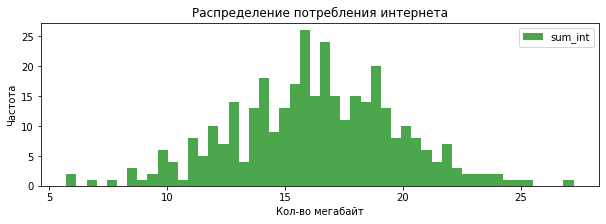

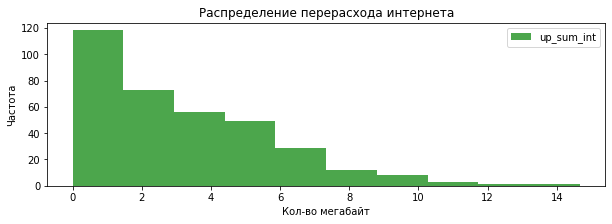

In [17]:
# Расчёт по интернету для тарифа Smart
print('Оценка интернета в тарифе Smart')
print('Средне-месячное потребление гигабайтов:',data_all_smart_p['sum_int'].mean())
print('Макс месячное потребление гигабайтов:',data_all_smart_p['sum_int'].max())
print('Средний перерасход гигабайт:',data_all_smart_p['up_sum_int'].mean())
print('Средняя переплата по интернету:',data_all_smart_p['up_sum_int'].mean()*200)

# Считаем сколько пользователей имеют перерасход по интернету по месяцам.
data_all_smart_count_hwo_over_int=data_all_smart.query('up_sum_int>0').pivot_table( index= 'month_user',values='up_sum_int',aggfunc='count')
# Считаем сколько пользователей всего в месяце.
data_all_smart_count_hwo_int=data_all_smart.pivot_table( index= 'month_user',values='user_id',aggfunc='count')
# Соединяем два предыдущих шага.
data_all_smart_count_hwo_over_int=pd.merge(data_all_smart_count_hwo_over_int,data_all_smart_count_hwo_int, on='month_user', how='inner')
# рассчитываем долю клиентов с перерасходом внутри тарифа по месяцам.
data_all_smart_count_hwo_over_int['avg_user_how_over_int']=data_all_smart_count_hwo_over_int['up_sum_int']/data_all_smart_count_hwo_over_int['user_id']

print('Средняя доля пользователей тарифа, которые вылетают за лимит по трафику :',data_all_smart_count_hwo_over_int['avg_user_how_over_int'].mean())

# Рассчитываем Стандартное отклонение и Дисперсию.
print('Стандартное отклонение интернету:',np.std(data_all_smart['sum_int']))
print('Дисперсия интернету:',(data_all_smart.var()['sum_int']))  

# Графики распределение
data_all_smart_p.plot(y=['sum_int'],kind='hist',bins=50, figsize=(10,3),alpha=0.7,color='green')
plt.title('Распределение потребления интернета')
plt.ylabel('Частота')
plt.xlabel('Кол-во мегабайт')
data_all_smart_p.plot(y='up_sum_int',kind='hist',bins=10, figsize=(10,3),alpha=0.7, color='green')
plt.title('Распределение перерасхода интернета')
plt.ylabel('Частота')
plt.xlabel('Кол-во мегабайт')

Средне-месячное кол-во сообщений: 32.352078231292516
Средний перерасход сообщений: 5.8796189445475155
Средняя переплата по сообщениям: 17.638856833642546
Средняя доля пользователей тарифа, которые вылетают за лимит по трафику : 0.22339564394656888
Стандартное отклонение кол-ва сообщений: 28.221542886898938
Дисперсия по кол-ву сообщений: 796.8129584480083


Text(0.5, 0, 'Кол-во минут')

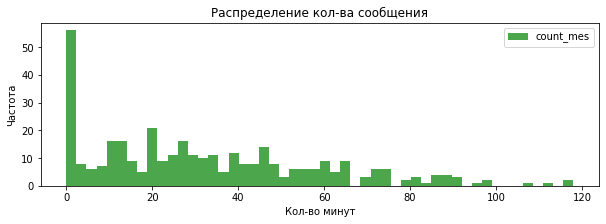

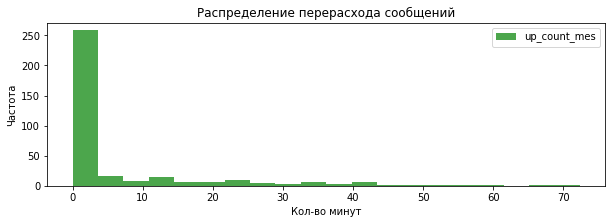

In [18]:
# Расчёт по сообщениям для тарифа Smart

print('Средне-месячное кол-во сообщений:',data_all_smart_p['count_mes'].mean())
print('Средний перерасход сообщений:',data_all_smart_p['up_count_mes'].mean())
print('Средняя переплата по сообщениям:',data_all_smart_p['up_count_mes'].mean()*3)

# Считаем сколько пользователей имеют перерасход по сообщениям по месяцам.
data_all_smart_count_hwo_over_mes=data_all_smart.query('up_count_mes>0').pivot_table( index= 'month_user',values='up_count_mes',aggfunc='count')
# Считаем сколько пользователей всего в месяце.
data_all_smart_count_hwo_mes=data_all_smart.pivot_table( index= 'month_user',values='user_id',aggfunc='count')
# Соединяем два предыдущих шага.
data_all_smart_count_hwo_over_mes=pd.merge(data_all_smart_count_hwo_over_mes,data_all_smart_count_hwo_mes, on='month_user', how='inner')
# рассчитываем долю клиентов с перерасходом внутри тарифа по месяцам.
data_all_smart_count_hwo_over_mes['avg_user_how_over_mes']=data_all_smart_count_hwo_over_mes['up_count_mes']/data_all_smart_count_hwo_over_mes['user_id']

print('Средняя доля пользователей тарифа, которые вылетают за лимит по трафику :',data_all_smart_count_hwo_over_mes['avg_user_how_over_mes'].mean())
# Рассчитываем Стандартное отклонение и Дисперсию.

print('Стандартное отклонение кол-ва сообщений:',np.std(data_all_smart['count_mes']))
print('Дисперсия по кол-ву сообщений:',(data_all_smart.var()['count_mes']))  
data_all_smart_p.plot(y=['count_mes'],kind='hist',bins=50, figsize=(10,3),alpha=0.7,color='green')
plt.title('Распределение кол-ва сообщения')
plt.ylabel('Частота')
plt.xlabel('Кол-во минут')
data_all_smart_p.plot(y='up_count_mes',kind='hist',bins=20, figsize=(10,3),alpha=0.7, color='green')
plt.title('Распределение перерасхода сообщений')
plt.ylabel('Частота')
plt.xlabel('Кол-во минут')

In [19]:
# Расчёт  по деньгам для тарифа Smart
# Рассчитываем сумму и кол-во пользователей имеющие переплаты по месяцам
data_all_smart_count_hwo_over_pay=data_all_smart.query('up_revenue_user>0').pivot_table( index= 'month_user',values='up_revenue_user',aggfunc=['count','sum'])
# Рассчитываем сумму и кол-во пользователей имеющие оплат по месяцам
data_all_smart_count_hwo_pay=data_all_smart.pivot_table( index= 'month_user',values='revenue_user',aggfunc=['count','sum'])
data_all_smart_count_hwo_over_pay.columns=['up_revenue_user_count','up_revenue_user_sum']
data_all_smart_count_hwo_pay.columns=['revenue_user_count','revenue_user_sum']
data_all_smart_count_hwo_over_pay.head()
#объединяем в одну таблицу.
data_all_smart_count_hwo_over_pay=pd.merge(data_all_smart_count_hwo_over_pay,data_all_smart_count_hwo_pay, on='month_user', how='inner')
# Доля пользователей с переплатой
data_all_smart_count_hwo_over_pay['avg_user_how_over_pay']=data_all_smart_count_hwo_over_pay['up_revenue_user_count']/data_all_smart_count_hwo_over_pay['revenue_user_count']
# Средний размер переплаты 
data_all_smart_count_hwo_over_pay['avg_pay_for_user']=data_all_smart_count_hwo_over_pay['up_revenue_user_sum']/data_all_smart_count_hwo_over_pay['revenue_user_count']
print('Оценка тарифа Smart по деньгам')
print('средняя выручка на одного пользователя:',(data_all_smart_count_hwo_pay['revenue_user_sum']/data_all_smart_count_hwo_pay['revenue_user_count']).mean())
print('Среднее доля пользователей с переплатой:',data_all_smart_count_hwo_over_pay['avg_user_how_over_pay'].mean())
print('Средняя переплата за пользователя в месяц:',data_all_smart_count_hwo_over_pay['avg_pay_for_user'].mean())
print('Максимальная перплата:',data_all_smart['up_revenue_user'].max())

Оценка тарифа Smart по деньгам
средняя выручка на одного пользователя: 1179.9244237841976
Среднее доля пользователей с переплатой: 0.6680239483655392
Средняя переплата за пользователя в месяц: 629.9244237841976
Максимальная перплата: 6220.0


<b>Описание тарифа:</b>  
Тариф Smart, рассчитан для клиентов из низкого ценового сегмента. Средняя выручка на пользователя не превышает 1179 руб.  
67% клиентов имеют переплату по тарифу в основном переплата возникает из-из перерасхода интернет трафика.  
Для графиков потребления минут и интернет трафика характерно нормальное распределение.  
Среднее-месячное кол-во минут (419) укладывается в лимиты по тарифу (500).    
Среднее-месячное кол-во сообщений (32) укладывается в лимиты по тарифу (50).  
Среднее-месячное кол-во гигабайт (16) не укладывается в лимиты по тарифу (15).  


## Тариф Ultra
Выбираем тариф Ultra и оцениваем сколько средне денег уходит у клиента, что вызывает наибольшую переплату по тарифу.  

In [20]:
data_all_ultra=data_all.loc[data_all['tariff']=='ultra']
data_all_ultra.head()

,user_id,month_user,count_call,sum_call,count_int,sum_int,count_mes,age,churn_date,city,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,up_sum_call,up_sum_int,up_count_mes,revenue_user,up_revenue_user
0,1000,2018-05,17.00,159.00,4.00,3.00,22.00,52,0,Краснодар,...,3000,1950,150,1,1,0.00,0.00,0.00,1950.00,0.00
1,1000,2018-06,28.00,172.00,44.00,23.00,60.00,52,0,Краснодар,...,3000,1950,150,1,1,0.00,0.00,0.00,1950.00,0.00
2,1000,2018-07,41.00,340.00,28.00,14.00,75.00,52,0,Краснодар,...,3000,1950,150,1,1,0.00,0.00,0.00,1950.00,0.00
3,1000,2018-08,42.00,408.00,27.00,14.00,81.00,52,0,Краснодар,...,3000,1950,150,1,1,0.00,0.00,0.00,1950.00,0.00
4,1000,2018-09,46.00,466.00,25.00,15.00,57.00,52,0,Краснодар,...,3000,1950,150,1,1,0.00,0.00,0.00,1950.00,0.00


Оценка тарифа  Ultra по звонкам. Перерасход отсутствует.

Среднее кол-во потраченных минут: 527.8218193030694
Максимальное кол-во потраченных минут: 1179.3636363636363
Среднее кол-во сообщений: 54.03074324324324
Максимальное кол-во потраченных сообщений: 224.0
Стандартное отклонение по минутам: 317.44483554974113
Стандартное отклонение по сообщениям: 47.78018496610161
Дисперсия минут разговора: 100873.63339730098
Дисперсия  сообщений: 2285.2661425446736


Text(0.5, 0, 'Кол-во минут')

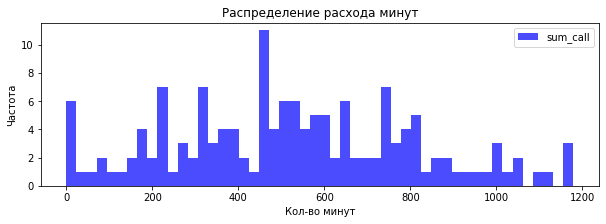

In [21]:
# усредняем показатели для каждого пользователя по месяцам:
data_all_ultra_p=data_all_ultra.pivot_table( index= 'user_id',values=['sum_call','sum_int','count_mes','up_sum_call','up_sum_int','up_count_mes'],aggfunc='mean')
print('Оценка тарифа  Ultra по звонкам. Перерасход отсутствует.')
print()
print('Среднее кол-во потраченных минут:',data_all_ultra_p['sum_call'].mean())
print('Максимальное кол-во потраченных минут:',data_all_ultra_p['sum_call'].max())
print('Среднее кол-во сообщений:',data_all_ultra_p['count_mes'].mean())
print('Максимальное кол-во потраченных сообщений:',data_all_ultra['count_mes'].max())
print('Стандартное отклонение по минутам:',np.std(data_all_ultra['sum_call']))
print('Стандартное отклонение по сообщениям:',np.std(data_all_ultra['count_mes']))
print('Дисперсия минут разговора:',data_all_ultra.var()['sum_call']) 
print('Дисперсия  сообщений:',data_all_ultra.var()['count_mes'])

data_all_ultra_p.plot(y=['sum_call'],kind='hist',bins=50, figsize=(10,3),alpha=0.7,color='blue')
plt.title('Распределение расхода минут')
plt.ylabel('Частота')
plt.xlabel('Кол-во минут')




Средне месячный трафик: 19.588446238446238
Средняя перерасход гигабайт: 0.9097643910143912
Средняя переплата по интернету: 136.46465865215868
Средняя доля пользователей тарифа, которые вылетают за лимит по трафику : 0.12801146498255334
Стандартное отклонение интернету: 9.848508314957495
Дисперсия интернету: 97.09168626965459


Text(0.5, 0, 'Кол-во минут')

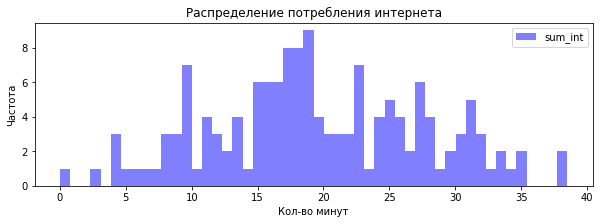

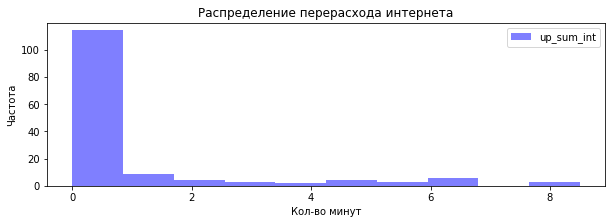

In [22]:
# Расчёт по интернету
print('Средне месячный трафик:',data_all_ultra_p['sum_int'].mean())
print('Средняя перерасход гигабайт:',data_all_ultra_p['up_sum_int'].mean())
print('Средняя переплата по интернету:',data_all_ultra_p['up_sum_int'].mean()*150)
# Считаем сколько пользователей имеют перерасход по интернету по месяцам.
data_all_ultra_count_hwo_over_int=data_all_ultra.query('up_sum_int>0').pivot_table( index= 'month_user',values='up_sum_int',aggfunc='count')
# Считаем сколько пользователей всего в месяце.
data_all_ultra_count_hwo_int=data_all_ultra.pivot_table( index= 'month_user',values='user_id',aggfunc='count')
# Соединяем два предыдущих шага.
data_all_ultra_count_hwo_over_int=pd.merge(data_all_ultra_count_hwo_over_int,data_all_ultra_count_hwo_int, on='month_user', how='inner')
# рассчитываем долю клиентов с перерасходом внутри тарифа по месяцам.
data_all_ultra_count_hwo_over_int['avg_user_how_over_int']=data_all_ultra_count_hwo_over_int['up_sum_int']/data_all_ultra_count_hwo_over_int['user_id']

print('Средняя доля пользователей тарифа, которые вылетают за лимит по трафику :',data_all_ultra_count_hwo_over_int['avg_user_how_over_int'].mean())
# Рассчитываем Стандартное отклонение и Дисперсию.
print('Стандартное отклонение интернету:',np.std(data_all_ultra['sum_int']))
print('Дисперсия интернету:',(data_all_ultra.var()['sum_int']))  

data_all_ultra_p.plot(y=['sum_int'],kind='hist',bins=50, figsize=(10,3),alpha=0.5,color='blue')
plt.title('Распределение потребления интернета')
plt.ylabel('Частота')
plt.xlabel('Кол-во минут')
data_all_ultra_p.plot(y=['up_sum_int'],kind='hist',bins=10, figsize=(10,3),alpha=0.5, color='blue')
plt.title('Распределение перерасхода интернета')
plt.ylabel('Частота')
plt.xlabel('Кол-во минут')

In [23]:
# Расчёт перерасхода по деньгам
data_all_ultra_count_hwo_over_pay=data_all_ultra.query('up_revenue_user>0').pivot_table( index= 'month_user',values='up_revenue_user',aggfunc=['count','sum'])
data_all_ultra_count_hwo_pay=data_all_ultra.pivot_table( index= 'month_user',values='revenue_user',aggfunc=['count','sum'])
data_all_ultra_count_hwo_over_pay.columns=['up_revenue_user_count','up_revenue_user_sum']
data_all_ultra_count_hwo_pay.columns=['revenue_user_count','revenue_user_sum']
data_all_ultra_count_hwo_over_pay.head()
data_all_ultra_count_hwo_over_pay=pd.merge(data_all_ultra_count_hwo_over_pay,data_all_ultra_count_hwo_pay, on='month_user', how='inner')
data_all_ultra_count_hwo_over_pay['avg_user_how_over_pay']=data_all_ultra_count_hwo_over_pay['up_revenue_user_count']/data_all_ultra_count_hwo_over_pay['revenue_user_count']
data_all_ultra_count_hwo_over_pay['avg_pay_for_user']=data_all_ultra_count_hwo_over_pay['up_revenue_user_sum']/data_all_ultra_count_hwo_over_pay['revenue_user_count']
print('средняя выручка на одного пользователя:',(data_all_ultra_count_hwo_pay['revenue_user_sum']/data_all_ultra_count_hwo_pay['revenue_user_count']).mean())
print('Среднее доля пользователей с переплатой:',data_all_ultra_count_hwo_over_pay['avg_user_how_over_pay'].mean())
print('Средняя переплата за пользователя в месяц:',data_all_ultra_count_hwo_over_pay['avg_pay_for_user'].mean())
print('Максимальная перплата:',data_all_ultra['up_revenue_user'].max())

средняя выручка на одного пользователя: 2046.9328563602276
Среднее доля пользователей с переплатой: 0.12801146498255334
Средняя переплата за пользователя в месяц: 105.74493421115722
Максимальная перплата: 2850.0


<b>Описание тарифа:</b>  
Тариф Ultra, рассчитан для клиентов не готовых переплачивать за тариф. Средняя выручка на пользователя не превышает 2046 руб.  
12% клиентов имеют переплату по тарифу в основном переплата возникает из-из перерасхода интернет трафика.  
Клиенты данного тарифа в среднем не выбирают лимиты. Особенно это заметно в звонках (потребление несильно больше, чем у Smart)
Для графиков потребления минут и интернет трафика характерно нормальное распределение.  
Среднее-месячное кол-во минут (527) укладывается в лимиты по тарифу (3000).    
Среднее-месячное кол-во сообщений (54) укладывается в лимиты по тарифу (1000).  
Среднее-месячное кол-во гигабайт (19) не укладывается в лимиты по тарифу (30).  
Данный тариф выбирают пользователи, которым явно не хватает 15 гигабайт интернета на тарифе Smart.


# Проверка гипотез

## Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Нулевая гипотеза: Средняя выручка тарифа "Ультра" равна  средней выручке по тарифу «Смарт»

Альтернативная гипотеза: Средняя выручка тарифа "Ультра" не равна  средней выручке по тарифу «Смарт» 

In [24]:
from scipy import stats as st
alpha = 0.05
results = st.ttest_ind(data_all_smart['revenue_user'],data_all_ultra['revenue_user'], equal_var = False)
print('P-value:', results.pvalue)
print('Средняя выручка по Smart:',data_all_smart['revenue_user'].mean())
print('Средняя выручка по Ultra:',data_all_ultra['revenue_user'].mean())
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 4.2606313931076085e-250
Средняя выручка по Smart: 1289.9735307312696
Средняя выручка по Ultra: 2070.1522842639592
Отвергаем нулевую гипотезу


Выводы: Нулевая гипотеза не подтвердилась. Выручка по тарифам не равна с уровнем значимости 5%.

## Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевая гипотеза: Средняя выручка в Москве равна средней выручке по тарифу в остальных регионах

Альтернативная гипотеза: Средняя выручка в Москве не равна средней выручке в остальных регионах

In [25]:
Moscow=data_all.loc[data_all['city']=='Москва']
unMoscow=data_all.loc[data_all['city']!='Москва']


from scipy import stats as st
alpha = 0.05
results = st.ttest_ind(Moscow['revenue_user'],unMoscow['revenue_user'], equal_var = False)
print('P-value:', results.pvalue)
print('Средняя выручка по Москве:',Moscow['revenue_user'].mean())
print('Средняя выручка не по Москве:',unMoscow['revenue_user'].mean())
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 0.5257376663729298
Средняя выручка по Москве: 1546.7135842880523
Средняя выручка не по Москве: 1524.9362274298885
Не получилось отвергнуть нулевую гипотезу


Выводы: Нулевая гипотеза подтвердилась. Следовательно, можно утверждать, что выручка в Москве и за ее пределами равны.

# Выводы

В процессе анализа данных были изучены клиентское поведение двух Тарифов:

Для тарифа Смарт характерна ежемесячная переплата по тарифу соизмеримая с самой стоимостью тарифа. Средняя переплата по тарифу составляет 591 руб и 67% клиентов имеют переплаты. Так же мы видим, что основным источником переплат является нехватка интернета. (в среднем клиенты тратят на 2.8 гигабайт больше лимита)

Для клиентов тарифа Ультра не свойственна переплата (только 12% пользователей имеют переплату в среднем 100 руб.)
При этом выручка с одно клиента в два раза выше, чем у тарифа Смарт (с учетом переплат)
Потребление голоса в среднем выше только 30%, а потребление интернета на 20%

Гипотеза о равенстве среднего выручки тарифов не подтвердилась.  
Гипотеза о равенстве выручки Москвы и других городов подтвердилась. 


Объективно мы видим что средняя выручка по тарифу Ultra выше Smart практически в два раза. Следовательно тариф Ultra выгоднее. Но оставлять один тариф для клиентов — это потенциальная угроза потери клиентов с низким ценником. 

